# Data Preprocessing
## Load Data And Dependencies

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [77]:
label_descriptions = {
    'TWF': 'Tool Wear Failure',
    'HDF': 'Heat Dissipation Failure',
    'PWF': 'Power Failure',
    'OSF': 'Overstrain Failure',
    'RNF': 'Random Failure'
}

https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset


In [78]:
df=pd.read_csv('ai4i2020.csv')
print(f"shape of data {df.shape}")
df.info()

shape of data (10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dt

In [79]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [80]:
print("Unique values in each column:")
for col in df.columns:
    unique_values = df[col].unique()
    if len(unique_values) < 10:
        print(f"{col:30} \t{unique_values}")
    else:   
        print(f"{col:30} \t{len(df[col].unique())} values")

Unique values in each column:
UDI                            	10000 values
Product ID                     	10000 values
Type                           	['M' 'L' 'H']
Air temperature [K]            	93 values
Process temperature [K]        	82 values
Rotational speed [rpm]         	941 values
Torque [Nm]                    	577 values
Tool wear [min]                	246 values
Machine failure                	[0 1]
TWF                            	[0 1]
HDF                            	[0 1]
PWF                            	[0 1]
OSF                            	[0 1]
RNF                            	[0 1]


From the unique values analysis above, we know that UDI and Product ID can be removed.

Both columns has 1000 unique values and we have 1000 rows of samples. 

Hence, the values are unique for each sample.

## Remove Row Unique ID and Product ID

In [81]:
df.drop(columns=['UDI', 'Product ID'], inplace=True)
print(f"shape of data after dropping columns {df.shape}")

shape of data after dropping columns (10000, 12)


## Max and Min For Numeric Values

In [82]:
exclude = ['Type','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df.drop(exclude, axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0


## Convert Type To Numeric

In [83]:
df['Type'] = df['Type'].astype('category')
type_mapping = {'L': 0, 'M': 1, 'H': 2}
df['Type'] = df['Type'].map(type_mapping).astype('int')
print(" Type  Unique Values after encoding: ", df['Type'].unique())

 Type  Unique Values after encoding:  [1 0 2]


## Check for Duplicates And Missing Data

In [84]:
print("number of duplicated rows : ", df.duplicated().sum())
print("number of null values : ", df.isnull().sum().sum())

number of duplicated rows :  0
number of null values :  0


Our data does not seem to have any duplicate or missing data.
This is given the data is synthetic data created through simulation.

## Check Our Target and Label

We want to check whether there is any machine failures that are not attributed to the 5 known failures

This should be changed to non failure as RNF already handled random failure.

Hence, this is data error and should have been a pass

In [85]:
# check machine failure


def unknown_fail_check(row): return ((row['Machine failure'] == 1)
                                     & (row['RNF'] == 0)
                                     & (row['HDF'] == 0)
                                     & (row['TWF'] == 0)
                                     & (row['PWF'] == 0)
                                     & (row['OSF'] == 0))


print(f"Number of machine failures: {df['Machine failure'].sum()}")
unknown_failures = df[unknown_fail_check(df)]
print(
    f"Number of failures due to unknown reasons: {len(unknown_failures)}")
unknown_failures.loc[:, ['Machine failure',
                         'TWF', 'HDF', 'PWF', 'OSF', 'RNF']].head(10)
df['Machine failure'] = np.where(
    unknown_fail_check(df), 0, df['Machine failure'])
unknown_failures = df[unknown_fail_check(df)]
print(
    f"Number of failures due to unknown reasons after fix: {len(unknown_failures)}")

Number of machine failures: 339
Number of failures due to unknown reasons: 9
Number of failures due to unknown reasons after fix: 0


In [86]:

def pass_yet_fail_check(row): return (row['Machine failure'] == 0) & ((row['RNF'] == 1)
                                                                     | (row['HDF'] == 1)
                                                                     | (row['TWF'] == 1)
                                                                     | (row['PWF'] == 1)
                                                                     | (row['OSF'] == 1))
passed_although_failed = df[pass_yet_fail_check(df)]
print(
    f"Number of samples that passed although failed: {len(passed_although_failed)}")
passed_although_failed.loc[:, ['Machine failure',
                               'TWF', 'HDF', 'PWF', 'OSF', 'RNF']].head(10)
df['Machine failure'] = np.where(
    pass_yet_fail_check(df), 1, df['Machine failure'])
passed_although_failed = df[pass_yet_fail_check(df)]
print(
    f"Number of samples that passed although failed after fix: {len(passed_although_failed)}")


Number of samples that passed although failed: 18
Number of samples that passed although failed after fix: 0


## Add New Features

From https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset
or https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020/data

We learned :

- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.


We know from our dataset documentation that the failures are related to 3 new features:
- Strain (minNm) = Product of Tool Wear and Torgue
- Power (W) = Product of rational speed and Torque 
- Temperature Difference (K) = difference of Process and Air Temperatures

Let's add these features

In [87]:
df['Strain [minNm]'] = df['Tool wear [min]'] * df['Torque [Nm]'] 
df['Power (W)'] = df['Rotational speed [rpm]'] * df['Torque [Nm]'] * 2 * np.pi / 60
df['Temperature Difference (K)'] = df['Process temperature [K]'] - df['Air temperature [K]']

## Save Data

In [88]:
df.to_csv('ai4i2020_cleaned.csv', index=False)

## Split Data to Training and Test Data

In [89]:
labels = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
X = df.drop(columns=labels)
y = df[labels]
print(f"shape of X {X.shape}, shape of y {y.shape}")
print(f"X columns {X.columns}")
print(f"y columns {y.columns}")
# Split the data into training and test sets
# We will use stratified sampling to ensure that the distribution of the target variable is preserved in both sets.
# This is important for imbalanced datasets.
# We will use a random state of 42 for reproducibility.
# We will also use a test size of 20% and a train size of 80%.  
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,  stratify=y['Machine failure']) 
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)


shape of X (10000, 9), shape of y (10000, 6)
X columns Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Strain [minNm]', 'Power (W)', 'Temperature Difference (K)'],
      dtype='object')
y columns Index(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], dtype='object')


In [90]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

## Check For Imbalance Data

Percentages of each label in training data:
Machine failure: 3.48%
TWF: 0.49%
HDF: 1.10%
PWF: 1.01%
OSF: 0.94%
RNF: 0.21%


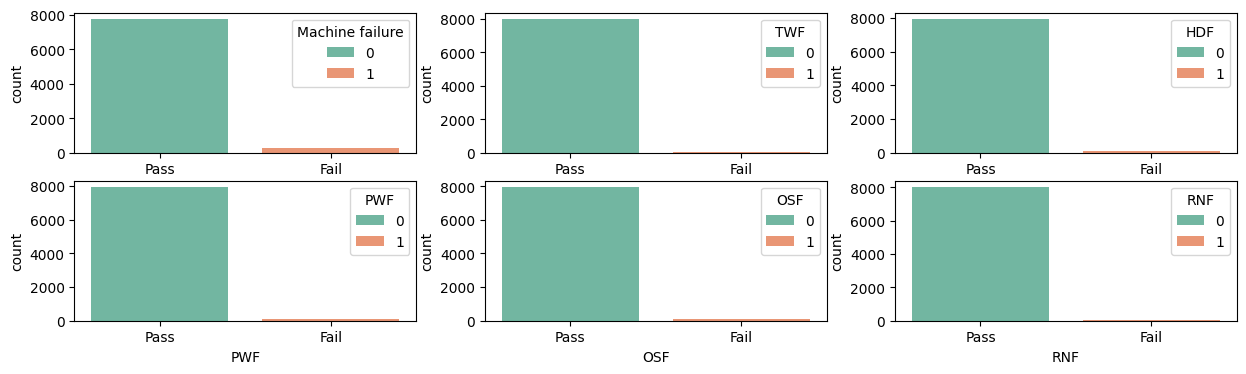

In [91]:
plt.figure(figsize=(15, 4))
percentages = y_train.mean() * 100
print("Percentages of each label in training data:")
for label, percentage in zip(labels, percentages):
    print(f"{label}: {percentage:.2f}%")
for index, label in enumerate(labels):
    plt.subplot(2, 3, index + 1) 
    sns.countplot(x=label, data=df_train, palette='Set2', hue=label, legend='full')
    plt.xticks([0, 1], ['Pass', 'Fail'])
plt.show()


We can observe that our data is highly imbalanced for all of our labels

We should create a balanced dataset for our training to avoid majority bias

## Balancing Dataset for Machine Failure

In [92]:
%pip install imblearn
# Check if the imbalanced-learn package is installed
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
y_omf = y_train["Machine failure"]
X_oversample_train, y_oversample_train = oversample.fit_resample(X_train, y_omf)
print(f"Oversampling completed with {len(y_oversample_train)} samples.")



Note: you may need to restart the kernel to use updated packages.
Oversampling completed with 15444 samples.


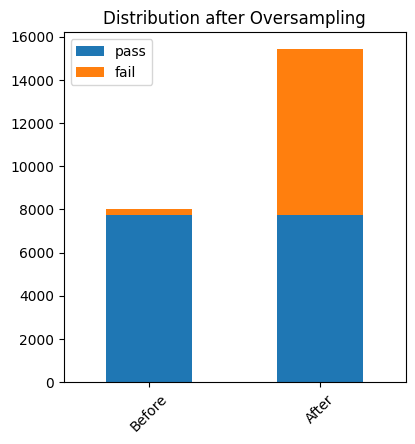

In [93]:

plt.figure(figsize=(15, 10))
before_count = y_omf.value_counts()
after_count = y_oversample_train.value_counts()
temp = pd.DataFrame({'pass': [before_count[0], after_count[0]],
                        'fail': [before_count[1], after_count[1]], },
                    index=['Before', 'After'])
temp.plot(kind='bar', stacked=True, ax=plt.subplot(2, 3, index + 1))
plt.xticks(rotation=45)
plt.title("Distribution after Oversampling")
plt.show()


## Saving Balanced DataSet

In [94]:
X_oversample_train.to_csv('X_oversample_train.csv', index=False)
y_oversample_train.to_csv('y_oversample_train.csv', index=False)

## MLSMOTE : Using Multi Label SMOTE to create a balanced dataset

This algorithm is based on https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote
Originally from https://www.sciencedirect.com/science/article/abs/pii/S0950705115002737
with some modifications
- input 
    - imbalanced dataset D with features X and labels Y
    - number of nearest neighbor to consider k
    - number of samples to generate per minority label N
- output
    - augmented dataset D'
- steps:
    - identify minority labels
        - for each label l in Y:
            - count positive instances
            - if count for l is < threshold (median), l is chosen as minority label
    - generate synthetic samples for each minority label l
        - for each minority label l:
            - let Sl = instances where Yi[l] = 1 (positive for label l)
            - for i = 1 to N
                - randomly select instance xi from Sl
                - find k-nearest neighbors of xi in Sl (using eucledian distance)
                - randomly select a neighbor xnn from k-nearest neighbor
                - compute a synthetic sample xnew:
                - assign a labels to xnew
                - add xnew, ynew to dataset D'     



In [95]:
from MultiLabelSMOTE import MultiLabelSMOTE
num_samples = np.sum(y_train['Machine failure'] == 0)-np.sum(y_train['Machine failure'] == 0)
print(f"Number of samples for oversampling: {num_samples}")
mlsmote = MultiLabelSMOTE(random_state=42, n_sample=num_samples)  # Adjust n_sample as needed
X_oversample_train, y_oversample_train = mlsmote.fit_resample(X_train, y_train)

print(f"Shape of oversampled X: {X_oversample_train.shape}, Shape of oversampled y: {y_oversample_train.shape}")
print("Oversampling completed using MultiLabelSMOTE.")
X_oversample_train.to_csv('X_oversample_train_mlsmote.csv', index=False)
y_oversample_train.to_csv('y_oversample_train_mlsmote.csv', index=False)
print("Oversampled data saved to CSV files.")    


Number of samples for oversampling: 0
Shape of oversampled X: (8000, 9), Shape of oversampled y: (8000, 6)
Oversampling completed using MultiLabelSMOTE.
Oversampled data saved to CSV files.


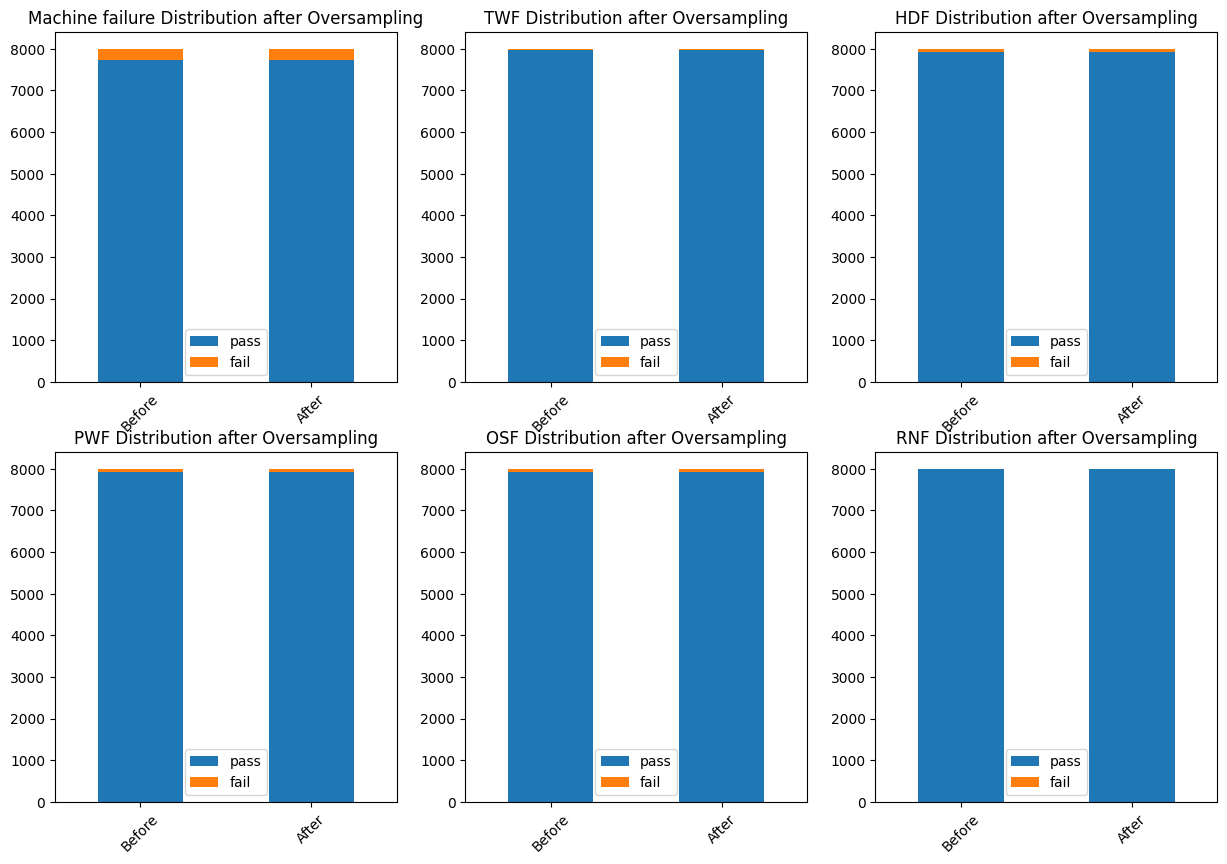

In [96]:
plt.figure(figsize=(15, 10))
for index, label in enumerate(labels):
    before_count = y_train[label].value_counts()
    after_count = y_oversample_train[label].value_counts()
    temp = pd.DataFrame({'pass': [before_count[0], after_count[0]],
                         'fail': [before_count[1], after_count[1]], },
                        index=['Before', 'After'])
    temp.plot(kind='bar', stacked=True, ax=plt.subplot(2, 3, index + 1))
    plt.xticks(rotation=45)
    plt.title(f"{label} Distribution after Oversampling")
plt.show()

Our algorithm produce a more balanced dataset with each label in similar propotion as the original dataset

In [97]:
before_counts = {}
after_counts = {}
before_count_machine_failure = y_train['Machine failure'].sum()
after_count_machine_failure = y_oversample_train['Machine failure'].sum()
for label in labels:
    before_counts[label] = y_train[label].sum() 
    after_counts[label] = y_oversample_train[label].sum() 
print("Percentage of samples before and after oversampling:")
for label in labels:
    print(f"{label}: Before: {before_counts[label]:.2f}%, After: {after_counts[label]:.2f}%") 

Percentage of samples before and after oversampling:
Machine failure: Before: 278.00%, After: 278.00%
TWF: Before: 39.00%, After: 39.00%
HDF: Before: 88.00%, After: 88.00%
PWF: Before: 81.00%, After: 81.00%
OSF: Before: 75.00%, After: 75.00%
RNF: Before: 17.00%, After: 17.00%
